# Face Mask Detection by Live Webcam

In [ ]:
import torch
import torch.nn as nn #its help to create and train Neural network
import torch.optim as optim #implementing various optimization algorithms
from torch.optim import lr_scheduler #learning rate scheduler, we can gradually decrease the learning rate value dynamically while training
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import shutil
import time
import copy

## [ 1 ] Data loading

In [ ]:
experiments_path = 'C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/'
data_path = 'C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/data/' 

## [ 2 ] Data pre-processing

In [ ]:
#train_data = experiments_path+'train'
# train_data = datasets.ImageFolder(root = train_dir, 
#                                   transform = transforms.ToTensor())

# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, label in train_data:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))

# means /= len(train_data)
# stds /= len(train_data)
    
# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

Now to actually load our data. As we are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision models page.

We use the same data augmentation as always: randomly rotating, flipping horizontally and cropping.

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #crop the images 
        transforms.ToTensor(),  # image to a pixel with range [0,1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize rgb image in same std and mean
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
        
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [ ]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)

## [ 3 ] Data Splitting

In [ ]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [ ]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [ ]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

File being copied from C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/data/with_mask\0-with-mask.jpg:C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/train\with_mask
File being copied from C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/data/with_mask\10-with-mask.jpg:C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/train\with_mask
File being copied from C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/data/with_mask\100-with-mask.jpg:C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/train\with_mask
File being copied from C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/data/with_mask\101-with-mask.jpg:C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/train\with_mask
File being copied from C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/data/with_mask\103-with-mask.jpg:C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/train\with_mask
File being co

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [ ]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1178
    Root location: C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: C:/Users/smit gandhi/Desktop/FACE mask temp/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']} #works for creating batch of 16 images and work on 4 images at a time

In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x216c36a6820>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x216c36a6b80>}

In [ ]:
class_names = image_datasets['train'].classes

In [ ]:
class_names

['with_mask', 'without_mask']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''CUDA (an acronym for Compute Unified Device Architecture) is a parallel 
computing platform and application programming interface (API) model created by Nvidia'''
device

device(type='cpu')

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

## [ 4 ] Visualizing images

In [ ]:

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean #optimize input image
    inp = np.clip(inp, 0, 1) #taking clip of value 0 to 1
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

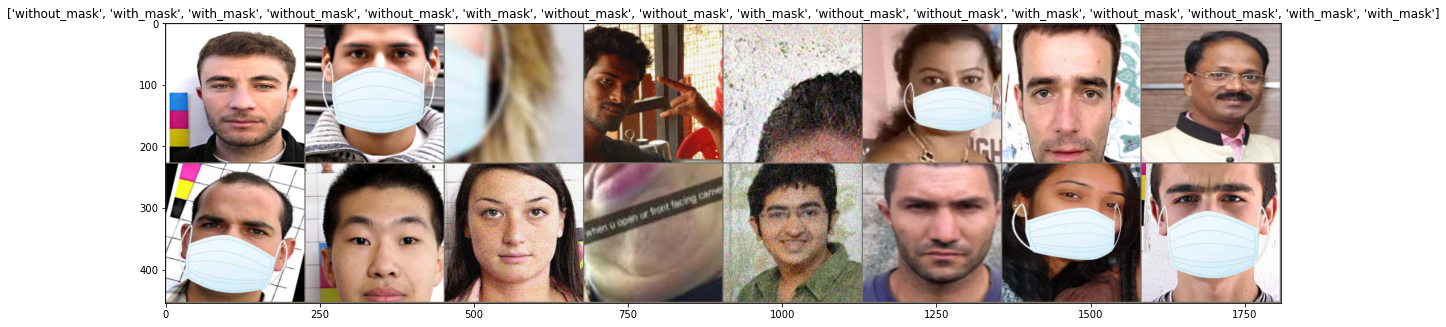

In [ ]:

imshow(out, title=[class_names[x] for x in classes])

## [ 5 ] Training the model

In [ ]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model

### [ 5.1 ] ResNet Model

In [ ]:
re_model_ft = models.resnet101(pretrained=True)

re_num_frts = re_model_ft.fc.in_features
re_model_ft.fc = nn.Linear(re_num_frts, len(class_names))

re_model_ft = re_model_ft.to(device)
criterion = nn.CrossEntropyLoss()
''' Adaptive Subgradient Methods (AdaGrad)? AdaGrad is a variation of 
stochastic gradient optimization algorithms that updates the learning rate for each parameter.'''
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(re_model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\smit gandhi/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth


In [ ]:
ResNetmodel_ft = train_model(re_model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


C:\Users\smit gandhi\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2030 Acc:0.9007

test Loss: 0.0047 Acc:1.0000

Epoch 1/19
----------
train Loss: 0.0847 Acc:0.9567

test Loss: 0.0006 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.0898 Acc:0.9584

test Loss: 0.0024 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.1206 Acc:0.9440

test Loss: 0.0014 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0796 Acc:0.9567

test Loss: 0.0015 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0726 Acc:0.9660

test Loss: 0.0015 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0926 Acc:0.9542

test Loss: 0.0006 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0668 Acc:0.9677

test Loss: 0.0005 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0614 Acc:0.9660

test Loss: 0.0006 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0577 Acc:0.9720

test Loss: 0.0004 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0635 Acc:0.9669

test Loss: 0.0004 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0610 Acc:0.9686

test Loss: 0.0004 Acc:1.0000

Epoch 12/19
----------
t

In [ ]:
torch.save(ResNetmodel_ft, 'C:/Users/smit gandhi/Desktop/FACE mask temp/maskmodel1_resnet101.pth')

Normalized confusion matrix:
[1. 0.]
[0. 1.]


Text(0.5, 23.09375, 'Predicted label')

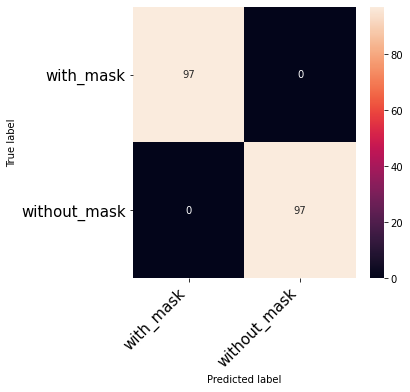

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = ResNetmodel_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(5,5))
print("============================================")
print(f"Normalized confusion matrix:")
for row in confusion_matrix:
    a = row / row.sum()
    n = np.round_(a, decimals = 4)
    print(n)
print("============================================")
class_names = ['with_mask', 'without_mask']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### [ 5.2 ] AlexNet Model

In [ ]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
#Model description
AlexNet_model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\smit gandhi/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\smit gandhi/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Updating the second classifier
AlexNet_model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
AlexNet_model.classifier[6] = nn.Linear(1024,2)

In [ ]:
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Verifying CUDA
print(device)
#Move the input and AlexNet_model to GPU for speed if available
AlexNet_model.to(device)

cpu


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.optim as optim
import torch.nn as nn
#Loss
criterion = nn.CrossEntropyLoss()
#Optimizer(SGD)
# optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
optimizer_ft = optim.Adagrad(AlexNet_model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
AlexNetmodel_ft = train_model(AlexNet_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


C:\Users\smit gandhi\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5441 Acc:0.7929

test Loss: 0.0715 Acc:0.9794

Epoch 1/19
----------
train Loss: 0.2080 Acc:0.9177

test Loss: 0.0233 Acc:0.9897

Epoch 2/19
----------
train Loss: 0.1572 Acc:0.9321

test Loss: 0.0168 Acc:0.9948

Epoch 3/19
----------
train Loss: 0.1169 Acc:0.9448

test Loss: 0.0072 Acc:0.9948

Epoch 4/19
----------
train Loss: 0.1178 Acc:0.9431

test Loss: 0.0092 Acc:0.9948

Epoch 5/19
----------
train Loss: 0.1004 Acc:0.9576

test Loss: 0.0150 Acc:0.9948

Epoch 6/19
----------
train Loss: 0.0960 Acc:0.9525

test Loss: 0.0191 Acc:0.9948

Epoch 7/19
----------
train Loss: 0.0935 Acc:0.9508

test Loss: 0.0208 Acc:0.9948

Epoch 8/19
----------
train Loss: 0.0778 Acc:0.9559

test Loss: 0.0206 Acc:0.9948

Epoch 9/19
----------
train Loss: 0.0889 Acc:0.9610

test Loss: 0.0198 Acc:0.9948

Epoch 10/19
----------
train Loss: 0.0798 Acc:0.9660

test Loss: 0.0209 Acc:0.9948

Epoch 11/19
----------
train Loss: 0.0854 Acc:0.9610

test Loss: 0.0198 Acc:0.9948

Epoch 12/19
----------
t

In [ ]:
torch.save(AlexNetmodel_ft, 'C:/Users/smit gandhi/Desktop/FACE mask temp/maskmodel2_Alexnet.pth')

Normalized confusion matrix:
[1. 0.]
[0.0103 0.9897]


Text(0.5, 23.09375, 'Predicted label')

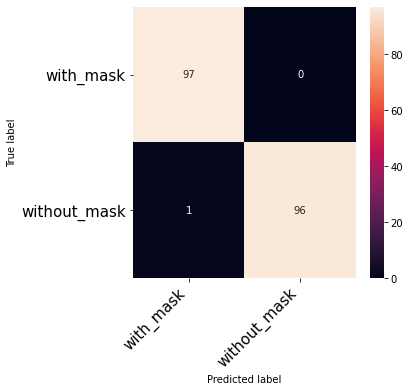

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = AlexNetmodel_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(5,5))
print("============================================")
print(f"Normalized confusion matrix:")
for row in confusion_matrix:
    a = row / row.sum()
    n = np.round_(a, decimals = 4)
    print(n)
print("============================================")
class_names = ['with_mask', 'without_mask']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')


### [ 5.3 ] GoogleNet Model

In [ ]:
go_model_ft = models.googlenet(pretrained=True)

go_num_frts = go_model_ft.fc.in_features
go_model_ft.fc = nn.Linear(go_num_frts, len(class_names))

go_model_ft = go_model_ft.to(device)
criterion = nn.CrossEntropyLoss()
''' Adaptive Subgradient Methods (AdaGrad)? AdaGrad is a variation of 
stochastic gradient optimization algorithms that updates the learning rate for each parameter.'''
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(go_model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
GoogleNetmodel_ft = train_model(go_model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.1479 Acc:0.9346

test Loss: 0.0080 Acc:0.9948

Epoch 1/19
----------
train Loss: 0.1074 Acc:0.9499

test Loss: 0.0034 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.0641 Acc:0.9618

test Loss: 0.0044 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.0731 Acc:0.9618

test Loss: 0.0045 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0787 Acc:0.9601

test Loss: 0.0020 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0715 Acc:0.9618

test Loss: 0.0044 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0678 Acc:0.9728

test Loss: 0.0115 Acc:0.9948

Epoch 7/19
----------
train Loss: 0.0588 Acc:0.9711

test Loss: 0.0095 Acc:0.9948

Epoch 8/19
----------
train Loss: 0.0652 Acc:0.9703

test Loss: 0.0057 Acc:0.9948

Epoch 9/19
----------
train Loss: 0.0623 Acc:0.9669

test Loss: 0.0063 Acc:0.9948

Epoch 10/19
----------
train Loss: 0.0703 Acc:0.9593

test Loss: 0.0038 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0703 Acc:0.9652

test Loss: 0.0054 Acc:0.9948

Ep

In [ ]:
torch.save(GoogleNetmodel_ft, 'C:/Users/smit gandhi/Desktop/FACE mask temp/maskmodel3_GoogleNet.pth')

Normalized confusion matrix:
[1. 0.]
[0. 1.]


Text(0.5, 23.09375, 'Predicted label')

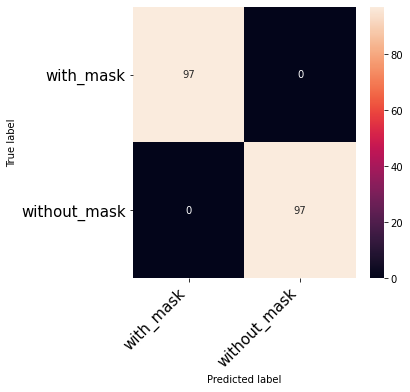

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = GoogleNetmodel_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(5,5))
print("============================================")
print(f"Normalized confusion matrix:")
for row in confusion_matrix:
    a = row / row.sum()
    n = np.round_(a, decimals = 4)
    print(n)
print("============================================")
class_names = ['with_mask', 'without_mask']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### [ 5.4 ] VGG Model

In [ ]:
### Define model
vg_model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
vg_model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\smit gandhi/.cache\torch\hub\checkpoints\vgg16-397923af.pth


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

vg_model.to(device)

criterion = nn.CrossEntropyLoss()
''' Adaptive Subgradient Methods (AdaGrad)? AdaGrad is a variation of 
stochastic gradient optimization algorithms that updates the learning rate for each parameter.'''
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(vg_model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
Vggmodel_ft = train_model(vg_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.2793 Acc:0.6851

test Loss: 0.0533 Acc:1.0000

Epoch 1/19
----------
train Loss: 0.2120 Acc:0.9261

test Loss: 0.0184 Acc:0.9948

Epoch 2/19
----------
train Loss: 0.1509 Acc:0.9533

test Loss: 0.0001 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.1251 Acc:0.9516

test Loss: 0.0078 Acc:0.9948

Epoch 4/19
----------
train Loss: 0.1081 Acc:0.9567

test Loss: 0.0000 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.1332 Acc:0.9423

test Loss: 0.0027 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.1047 Acc:0.9584

test Loss: 0.0026 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0989 Acc:0.9516

test Loss: 0.0017 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0955 Acc:0.9576

test Loss: 0.0013 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0966 Acc:0.9525

test Loss: 0.0007 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0775 Acc:0.9576

test Loss: 0.0004 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0725 Acc:0.9643

test Loss: 0.0003 Acc:1.0000

Ep

In [ ]:
torch.save(Vggmodel_ft, 'C:/Users/smit gandhi/Desktop/FACE mask temp/maskmodel4_vgg.pth')

Normalized confusion matrix:
[1. 0.]
[0. 1.]


Text(0.5, 23.09375, 'Predicted label')

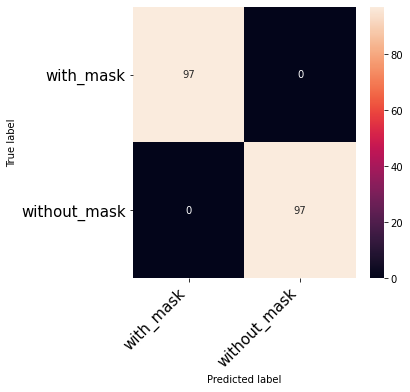

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
nb_classes = 2
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = Vggmodel_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(5,5))
print("============================================")
print(f"Normalized confusion matrix:")
for row in confusion_matrix:
    a = row / row.sum()
    n = np.round_(a, decimals = 4)
    print(n)
print("============================================")
class_names = ['with_mask', 'without_mask']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## [ 6 ] Visualizing model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(ResNetmodel_ft)

tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]) predicitons
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: with_mask predicted: with_mask


In [ ]:
visualize_model(AlexNetmodel_ft)

tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]) predicitons
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: with_mask predicted: with_mask


In [ ]:
visualize_model(GoogleNetmodel_ft)

tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]) predicitons
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: with_mask predicted: with_mask


In [ ]:
visualize_model(Vggmodel_ft)

tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]) predicitons
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
